In [1]:
import os   #linar regression for binary classes
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay

from sklearn.datasets import make_blobs,load_breast_cancer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
inpDir = os.path.join( '..', 'input')


###moduleDir = 'MACHINE LEARNING'

outDir = os.path.join('output')


# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 150,
          'image.cmap': 'jet',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }
CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE=0.2

<Figure size 1500x600 with 0 Axes>

In [3]:
titanic_df = pd.read_csv(os.path.join(inpDir, 'titanic.csv'))
titanic_df

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,1
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,1
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,0
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,0
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,0
...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,0
1305,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,0
1306,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,0
1307,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,0


In [4]:
def fn_plot_decision_boundary(pred_func,X,y,ax=None):
    '''
    Attrib:
        pred_func : function based on predict method of the classifer
        x: feature matrix
        y: targets
        ax:Matplotlib axis object
    Return:
        None
    '''
    #if ax is not supplied pick content of graph
    if ax is None:
        ax=plt.gca()

    # set min and max values and give it some padding
    xMin,xMax = X[:,0].min() - .05, X[:,0].max()  + .05
    yMin,yMax = X[:,1].min() - .05, X[:,1].max()  + .05
    
    #grid size for mesh grid
    h=0.05

    #generate a grid of points with distance'h between them
    xx , yy = np.meshgrid(np.arange(xMin , xMax , h) , np.arange(yMin , yMax , h))

    #predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(),yy.ravel()])

    #make its shape same as that of xx
    Z = Z.reshape(xx.shape)

    #now we have Z value corresponding ti each of the combination of xx and yy
    #plot the contour and training examples
    ax.contourf(xx , yy , Z ,cmap=CMAP , alpha=0.6)

    #plot the points as well
    ax.scatter(X[:,0],X[:,1], c=y,cmap=CMAP, edgecolors='black')

In [5]:
for col in titanic_df.columns:
    print(col,':', titanic_df[col].unique(),"\n")

pclass : [1 2 3] 

name : ['Allen, Miss. Elisabeth Walton' 'Allison, Master. Hudson Trevor'
 'Allison, Miss. Helen Loraine' ... 'Zakarian, Mr. Mapriededer'
 'Zakarian, Mr. Ortin' 'Zimmerman, Mr. Leo'] 

sex : ['female' 'male'] 

age : [29.      0.9167  2.     30.     25.     48.     63.     39.     53.
 71.     47.     18.     24.     26.     80.         nan 50.     32.
 36.     37.     42.     19.     35.     28.     45.     40.     58.
 22.     41.     44.     59.     60.     33.     17.     11.     14.
 49.     76.     46.     27.     64.     55.     70.     38.     51.
 31.      4.     54.     23.     43.     52.     16.     32.5    21.
 15.     65.     28.5    45.5    56.     13.     61.     34.      6.
 57.     62.     67.      1.     12.     20.      0.8333  8.      0.6667
  7.      3.     36.5    18.5     5.     66.      9.      0.75   70.5
 22.5     0.3333  0.1667 40.5    10.     23.5    34.5    20.5    30.5
 55.5    38.5    14.5    24.5    60.5    74.      0.4167 11.5    26.5

In [6]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   name      1309 non-null   object 
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   ticket    1309 non-null   object 
 7   fare      1308 non-null   float64
 8   cabin     295 non-null    object 
 9   embarked  1307 non-null   object 
 10  survived  1309 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


In [7]:
titanic_df.describe()

,pclass,age,sibsp,parch,fare,survived
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479,0.381971
std,0.837836,14.413500,1.041658,0.865560,51.758668,0.486055
min,1.000000,0.166700,0.000000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


In [8]:
titanic_df.isnull().sum()

pclass         0
name           0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
survived       0
dtype: int64

In [9]:
drop_col = ['name','ticket','cabin','fare']

titanic_df = titanic_df.drop(drop_col,axis = 1)
titanic_df.head()

,pclass,sex,age,sibsp,parch,embarked,survived
0,1,female,29.0000,0,0,S,1
1,1,male,0.9167,1,2,S,1
2,1,female,2.0000,1,2,S,0
3,1,male,30.0000,1,2,S,0
4,1,female,25.0000,1,2,S,0


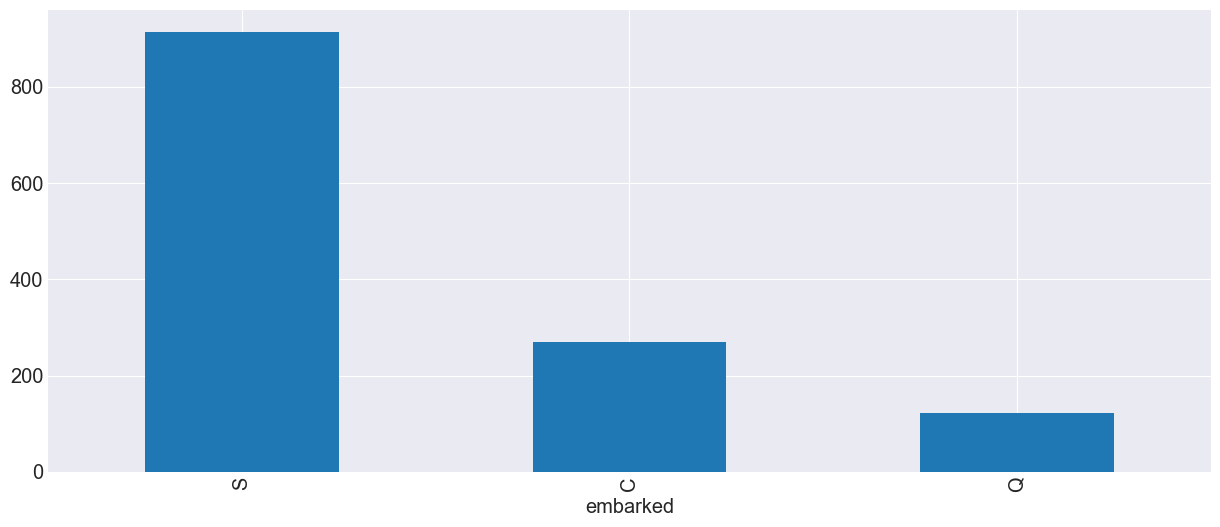

In [10]:
titanic_df.embarked.value_counts().plot(kind='bar');

In [11]:
titanic_df['embarked'] = titanic_df['embarked'].fillna(titanic_df.embarked.mode()[0])

titanic_df[titanic_df.embarked.isnull()]

,pclass,sex,age,sibsp,parch,embarked,survived


In [12]:
data_df = titanic_df['age'].fillna(titanic_df['age'].mean()).copy()

data_df[[15,37]]

15    29.881135
37    29.881135
Name: age, dtype: float64

In [13]:
class_mean = titanic_df.pivot_table('age',columns = 'sex',aggfunc = 'mean')
class_mean                                    

sex,female,male
age,28.687071,30.585233


In [14]:
titanic_df['age']=titanic_df[['age','sex']].apply(
    lambda x: class_mean[x['sex']]['age'] if pd.isnull(x['age'])else x ['age'],axis = 1
 )

In [15]:
# First, calculate the mean age for each sex
class_mean = titanic_df.groupby('sex')['age'].mean()

# Then, apply the function to fill missing values
titanic_df['age'] = titanic_df[['age','sex']].apply(
    lambda x: class_mean[x['sex']] if pd.isnull(x['age']) else x['age'], axis=1
)
class_mean

sex
female    28.687071
male      30.585233
Name: age, dtype: float64

In [16]:
titanic_df.iloc[[15,37,59]]

,pclass,sex,age,sibsp,parch,embarked,survived
15,1,male,30.585233,0,0,S,0
37,1,male,30.585233,0,0,S,1
59,1,female,28.687071,0,0,C,1


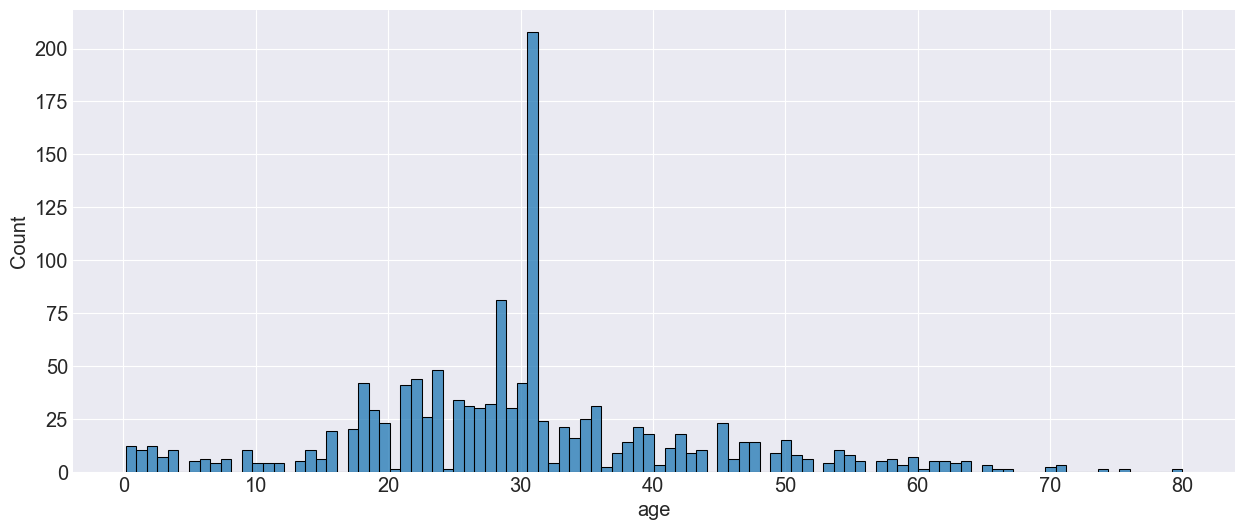

In [17]:
sns.histplot(titanic_df, x = 'age', bins = 100);

In [18]:
titanic_df = pd.get_dummies(titanic_df,columns=['embarked'],dtype=np.int16)
titanic_df.head()

,pclass,sex,age,sibsp,parch,survived,embarked_C,embarked_Q,embarked_S
0,1,female,29.0000,0,0,1,0,0,1
1,1,male,0.9167,1,2,1,0,0,1
2,1,female,2.0000,1,2,0,0,0,1
3,1,male,30.0000,1,2,0,0,0,1
4,1,female,25.0000,1,2,0,0,0,1


In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(titanic_df['sex'])
      
print('Classes found:',le.classes_)

titanic_df['sex'] = le.transform(titanic_df['sex'])

titanic_df.head()

Classes found: ['female' 'male']


,pclass,sex,age,sibsp,parch,survived,embarked_C,embarked_Q,embarked_S
0,1,0,29.0000,0,0,1,0,0,1
1,1,1,0.9167,1,2,1,0,0,1
2,1,0,2.0000,1,2,0,0,0,1
3,1,1,30.0000,1,2,0,0,0,1
4,1,0,25.0000,1,2,0,0,0,1


In [20]:
y = titanic_df['survived'].to_numpy()
X = titanic_df.drop('survived', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   stratify = y,
                                                   test_size = TEST_SIZE,
                                                   random_state = RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1047, 8), (262, 8), (1047,), (262,))

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
clf = LogisticRegression()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8015267175572519

### SMOTE

In [23]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [24]:
X, y = make_classification(n_classes = 2, class_sep = 2,
                          weights = [0.1, 0.9], n_informative = 3,
                          n_redundant = 1, flip_y = 0, n_features = 20,
                          n_clusters_per_class = 1, n_samples = N_SAMPLES, 
                          random_state = RANDOM_STATE)

In [25]:
y.shape

(1000,)

In [26]:
#import imblearn
#imblearn.__version__

In [27]:
sm = SMOTE(random_state = RANDOM_STATE)
X_sm, y_sm = sm.fit_resample(X, y)
Counter(y_sm)

AttributeError: 'NoneType' object has no attribute 'split'

NameError: name 'X_sm' is not defined

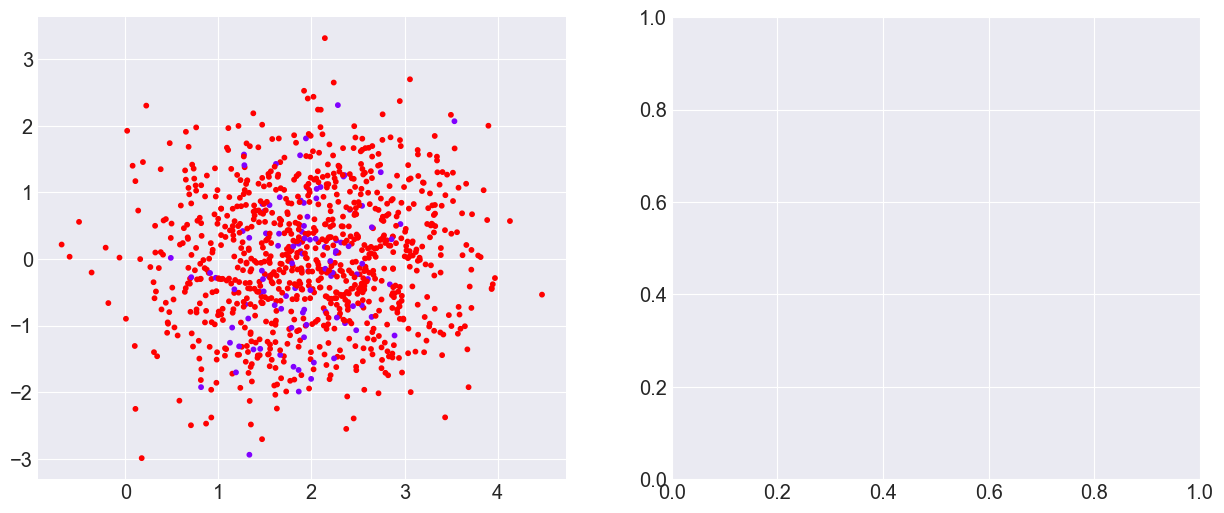

In [28]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(X[:,0], X[:,1], c = y, cmap = CMAP, s = 10)
axes[1].scatter(X_sm[:,0], X_sm[:,1], c = y_sm, cmap = CMAP, s = 10)

### Data Standardization

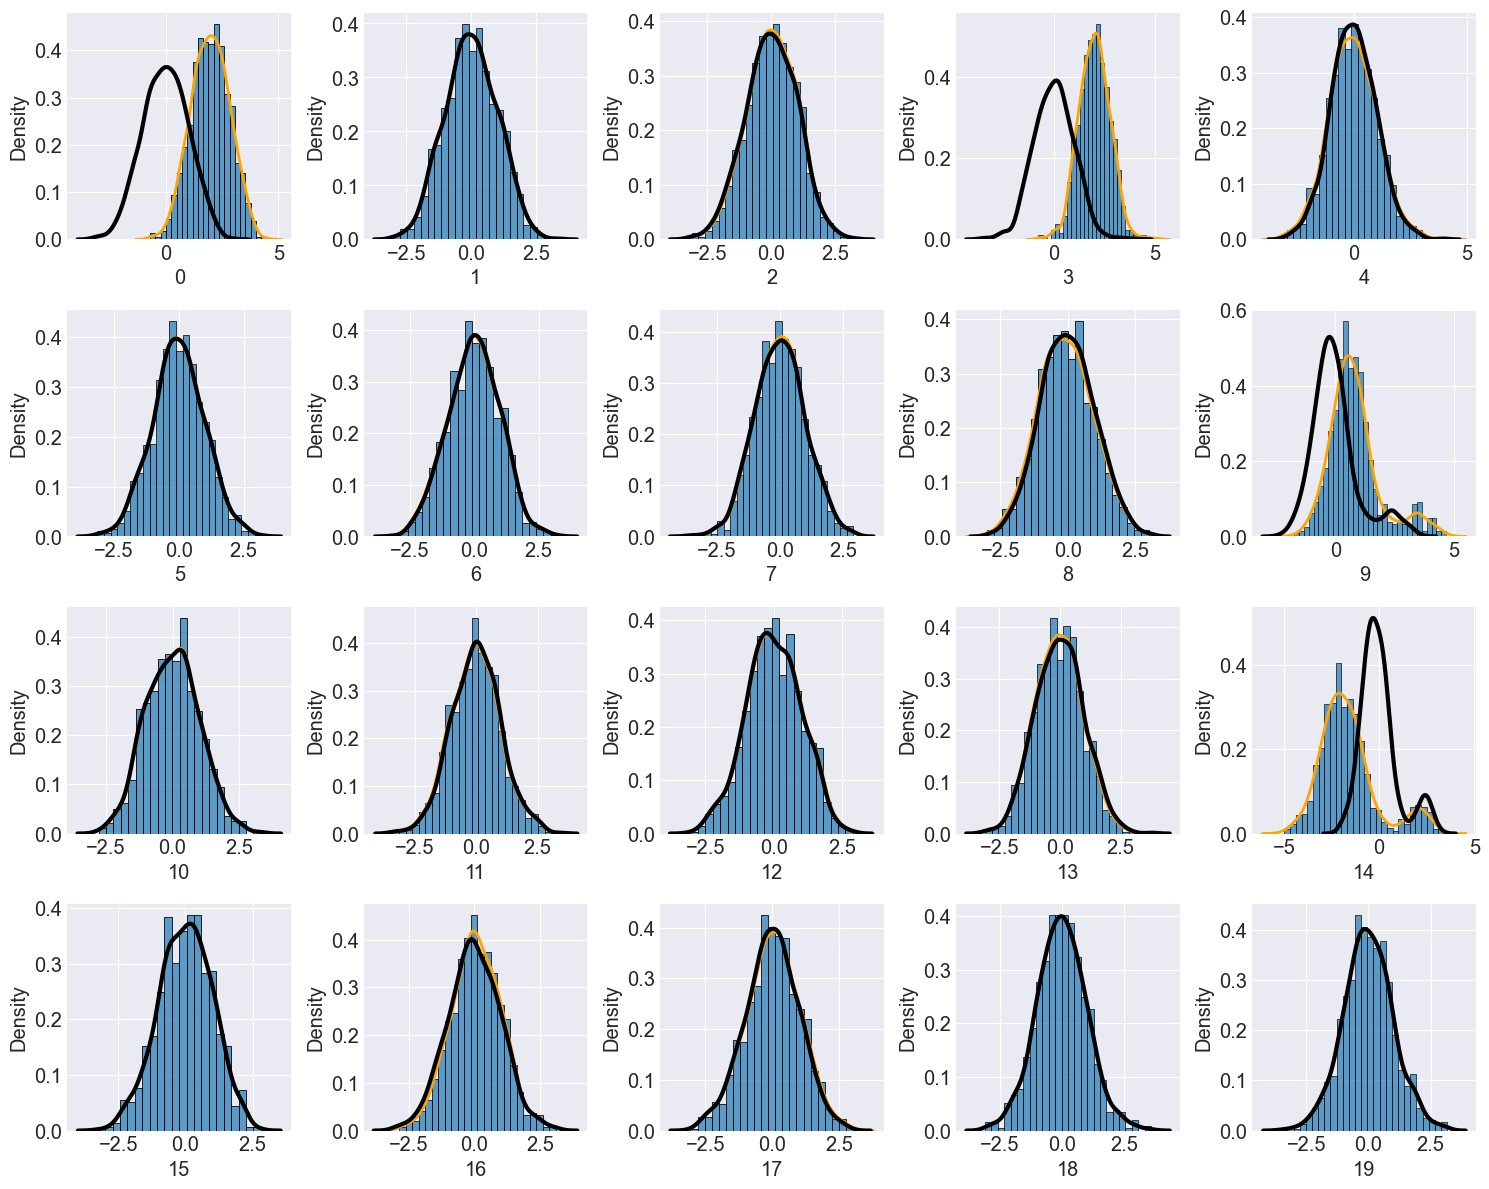

In [37]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

sc = StandardScaler()

data_df = pd.DataFrame(X)

mm_df = pd.DataFrame(mms.fit_transform(X))

sc_df = pd.DataFrame(sc.fit_transform(X))

fig, axes = plt.subplots(4,5, figsize = (15,12))

axes = axes.ravel()

for k in data_df.keys():
    ax = axes[k]
    
    sns.histplot(data_df, x = k, ax = ax, alpha = 0.7, stat = 'density')
    sns.kdeplot(data_df, x = k, ax = ax, c = 'orange', lw = 2)
    
    sns.kdeplot(sc_df, x = k, ax = ax, c = 'black', lw = 3)
    #sns.kdeplot(mm_df, x = k, ax = ax, c = 'green', lw = 3)

plt.tight_layout()